### By Vaasudevan Srinivasan ([vaasudevans.github.io](https://vaasudevans.github.io))
Created: April 9, 2019

Modified : April 11, 2019

In [1]:
# Download the datasets to this session

# IRIS dataset
!wget "https://raw.githubusercontent.com/VaasuDevanS/SVM-in-RemoteSensing/master/Implementation/Data/iris-data.txt" -qO "iris-data.txt"

# SVM for satellite imagery    
!wget "https://github.com/VaasuDevanS/SVM-in-RemoteSensing/blob/master/Implementation/Data/Dataset.tif?raw=true" -qO "Dataset.tif"
!wget "https://github.com/VaasuDevanS/SVM-in-RemoteSensing/blob/master/Implementation/Data/trainingSites.tif?raw=true" -qO "trainingSites.tif"
!wget "https://github.com/VaasuDevanS/SVM-in-RemoteSensing/blob/master/Implementation/Data/MaxLikelihood.tif?raw=true" -qO "MaxLikelihood.tif"
    
# Linux command to display the MetaData of the data
!gdalinfo Dataset.tif -nomd

Driver: GTiff/GeoTIFF
Files: Dataset.tif
Size is 250, 250
Coordinate System is:
PROJCS["WGS 84 / UTM zone 15N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-93],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32615"]]
Origin = (462405.000000000000000,1741815.000000000000000)
Pixel Size = (30.000000000000000,-30.000000000000000)
Corner Coordinates:
Upper Left  (  46240

## SVM for Iris dataset (presentation talk)

In [0]:
# Import the modules
from mlxtend.plotting import plot_decision_regions
from sklearn import svm, model_selection as ms
from sklearn.metrics import *
import matplotlib.pyplot as plt
import pandas as pd

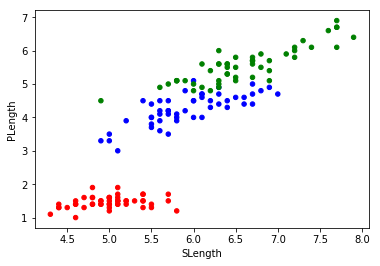

In [3]:
# Load the Dataset
cols = ["SLength", "SWidth", "PLength", "PWidth", "Class"]
types = ["Setosa", "Versicolor", "Virginica"]
iris = pd.read_csv("iris-data.txt", sep="\t", names=cols)

# Plot the values (plotting is done with pandas)
colors = [{1:'red', 2:'blue', 3:'green'}[i] for i in iris.Class]
iris.plot.scatter(x='SLength', y='PLength', c=colors)

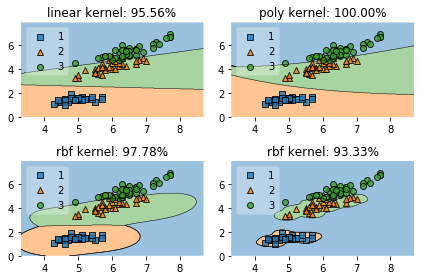

In [4]:
# Split the Dataset into Training (70%) and Testing(30%)
iris_len = pd.DataFrame([iris.SLength, iris.PLength, iris.Class]).transpose()
train, test = ms.train_test_split(iris_len, test_size=0.3, random_state=1)
cTrain, cTest = train.pop('Class'), test.pop('Class')


# Test the trained model with various SVM models and visualize them
for params,p in [({'kernel': 'linear', 'C': 1.0}, 221),
                 ({'kernel': 'poly', 'gamma': 0.1}, 222),
                 ({'kernel': 'rbf', 'gamma': 1}, 223),
                 ({'kernel': 'rbf', 'gamma': 20}, 224)
                ]:
    
    # Classifier
    clf = svm.SVC(**params)
    clf.fit(train, cTrain)

    # Predict
    accuracy = accuracy_score(cTest, clf.predict(test)) *100

    # Prepare for visualising the Hyper-plane
    X, Y = train.values, cTrain.values.astype(pd.np.integer)
    
    # Plot the hyperplane
    ttl = "%s kernel: %.2f%%" % (params['kernel'], accuracy)
    plt.subplot(p)
    plt.title(ttl)
    plot_decision_regions(X=X, y=Y, clf=clf, legend=2)
    
plt.tight_layout()
plt.show()

## SVM for Imagery using sklearn

In [0]:
# Importing the modules

import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
from sklearn.metrics import *
from sklearn import svm
import numpy as np

In [0]:
# Inorder to see the accuracy of SVM Classifier, it is assumed that
# MLC classifier performed in ArcGIS is 100% accurate

inRaster = "Dataset.tif"
trainRaster = "trainingSites.tif"
goldStdRaster = "MaxLikelihood.tif"

RGB = (4,3,2) # Specify the RGB bands for visualisation
classes = {'0':"Forest", '1':"Urban", '2':"Water", '3':"Barren Land"}

In [7]:
# Load the dataset and access the raster properties
ds = gdal.Open(inRaster)
cols, rows = ds.RasterXSize, ds.RasterYSize
bands = ds.RasterCount
dsType = gdal_array.GDALTypeCodeToNumericTypeCode(ds.GetRasterBand(1).DataType)
dsProj = ds.GetProjection()
dsTransform = ds.GetGeoTransform()
print("Shape: %s | type: %s | Bands: %s" % ((rows, cols), dsType, bands))

# Create a numpy array with all the bands from the input raster
imgArr = np.zeros((cols, rows, bands), dsType)
for band in range(bands):
    imgArr[:,:,band] = ds.GetRasterBand(band+1).ReadAsArray()

# Load the Training class raster
train_ds = gdal.Open(trainRaster)
trainArr = train_ds.GetRasterBand(1).ReadAsArray()
print("Training classes present: ", np.unique(trainArr))

# Load the Gold Standard raster
goldStd_ds = gdal.Open(goldStdRaster)
goldStdArr = goldStd_ds.GetRasterBand(1).ReadAsArray()

Shape: (250, 250) | type: <class 'numpy.int16'> | Bands: 8
Training classes present:  [0 1 2 3 4]


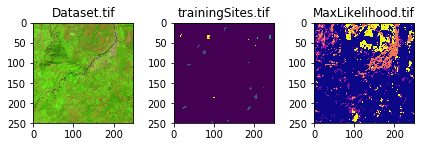

In [8]:
# Visualize the dataset and training sites using matplotlib

# Converted to 8-bit image using np.interp just for visualization
imgPlt = np.interp(imgArr,
                   (imgArr.min(), imgArr.max()), 
                   (0,255)).astype(np.uint8)

plt.subplot(131)
plt.imshow(imgPlt[:,:,RGB])
plt.title(inRaster)

plt.subplot(132)
plt.imshow(trainArr)
plt.title(trainRaster)

plt.subplot(133)
plt.imshow(goldStdArr, cmap='plasma')
plt.title(goldStdRaster)

plt.tight_layout()
plt.show()

In [9]:
# Prepare the Dataset for Training
# Step1: Create a mask from the training raster. values > 0
# Step2: Apply mask on the Original arr to get the X parameter for the model
# Step3: Apply mask on the training raster to get Y parameter for the model

# trainX will become scalar vector of `trainY` length with `n` dimensions

mask = trainArr > 0
trainX = imgArr[mask]
trainY = trainArr[mask]
print("Model-X: %s; Model-Y: %s" % (trainX.shape, trainY.shape))

Model-X: (573, 8); Model-Y: (573,)


In [10]:
# Helper functions and variables for model training and reporting

# Create a new shape for predicting the whole image to match with the trained
# model shape
newShape = (imgArr.shape[0] * imgArr.shape[1], imgArr.shape[2])

# Change the Image array to the new shape
testArr = imgArr.reshape(newShape)
print("%s is changed to %s" % (imgArr.shape, testArr.shape))

# Prepare the GoldStd array for classifier report
goldStd = goldStdArr.reshape(newShape[0])

# Generic function for printing out the classifier's report
def print_report(predicted):
    accuracy = accuracy_score(goldStd, predicted)
    print(f"Accuracy: {accuracy*100:.2f} %\n")
    print(classification_report(goldStd, predicted, target_names=classes))
    print(confusion_matrix(goldStd, predicted_lin))

(250, 250, 8) is changed to (62500, 8)


In [11]:
# Train the SVM Linear model with C value of 0.9
clfLinear = svm.SVC(kernel="linear", C=0.9)
clfLinear.fit(trainX, trainY)

# To get the Support Vectors, uncomment the below line and execute
# print(clfLinear.support_vectors_)

# Predicting for the whole image
predicted_lin = clfLinear.predict(testArr)

# Print the classifier reports
print_report(predicted_lin)

Accuracy: 81.96 %

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     48203
           1       0.13      0.06      0.08      5325
           2       0.67      0.08      0.14      4483
           3       0.56      0.57      0.56      4489

   micro avg       0.82      0.82      0.82     62500
   macro avg       0.56      0.42      0.43     62500
weighted avg       0.77      0.82      0.77     62500

[[48025     0    76   102]
 [ 4563   313    35   414]
 [  814  1821   340  1508]
 [ 1621   271    53  2544]]


In [12]:
# Train the SVM polynomial model with gamma value of 1.0 and coef0 as 100
clfPoly = svm.SVC(kernel="poly", gamma=1.0, coef0=100)
clfPoly.fit(trainX, trainY)

# Predicting for the whole image
predicted_poly = clfPoly.predict(testArr)

# Print the classifier reports
print_report(predicted_poly)

Accuracy: 82.05 %

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     48203
           1       0.17      0.10      0.12      5325
           2       0.52      0.07      0.12      4483
           3       0.46      0.78      0.58      4489

   micro avg       0.82      0.82      0.82     62500
   macro avg       0.52      0.48      0.44     62500
weighted avg       0.79      0.82      0.79     62500

[[48025     0    76   102]
 [ 4563   313    35   414]
 [  814  1821   340  1508]
 [ 1621   271    53  2544]]


In [13]:
# Train the SVM RBF (Radial Bias Function) model with gamma value of 1.0
clfRBF = svm.SVC(kernel="rbf", gamma=1.0)
clfRBF.fit(trainX, trainY)

# Predicting for the whole image
predicted_rbf = clfRBF.predict(testArr)

# Print the classifier reports
print_report(predicted_rbf)

Accuracy: 77.24 %

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     48203
           1       0.00      0.00      0.00      5325
           2       0.88      0.00      0.01      4483
           3       0.55      0.01      0.03      4489

   micro avg       0.77      0.77      0.77     62500
   macro avg       0.55      0.25      0.23     62500
weighted avg       0.70      0.77      0.68     62500

[[48025     0    76   102]
 [ 4563   313    35   414]
 [  814  1821   340  1508]
 [ 1621   271    53  2544]]


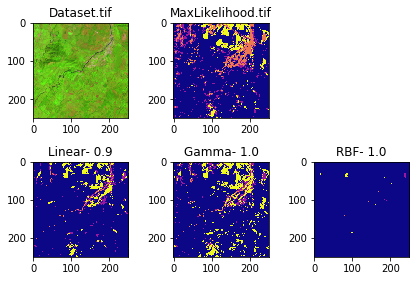

In [14]:
# Convert the predicted shape to image shape for Visualisation and saving 
imgShp = imgArr.shape[:-1]

# Visualise the Image again!
plt.subplot(231)
plt.imshow(imgPlt[:,:,(4,3,2)])
plt.title(inRaster)

# Visualise the GoldStandard again!
plt.subplot(232)
plt.imshow(goldStdArr, cmap='plasma')
plt.title(goldStdRaster)

# Visualise the Predicted classes Rasters
plt.subplot(234)
plt.imshow(predicted_lin.reshape(imgShp), cmap='plasma')
plt.title("Linear- 0.9")

plt.subplot(235)
plt.imshow(predicted_poly.reshape(imgShp), cmap='plasma')
plt.title("Gamma- 1.0")

plt.subplot(236)
plt.imshow(predicted_rbf.reshape(imgShp), cmap='plasma')
plt.title("RBF- 1.0")

plt.tight_layout()
plt.show()

In [0]:
# Write the classified rasters using GDAL
def save_classified(data, outfile):
    
    # Create a Driver for GTiff
    driver = gdal.GetDriverByName('GTiff')
    driver.Register()
    
    # Create a Dataset
    outDataset = driver.Create(outfile, cols, rows, 1, gdal.GDT_Byte)
    outDataset.SetGeoTransform(dsTransform)
    outDataset.SetProjection(dsProj)
    
    # Write the raster array to the Dataset
    outBand = outDataset.GetRasterBand(1)
    outBand.WriteArray(data, 0, 0)

# Predicted should be reshaped to match with the image shape
# The following line can be modified for any satisfying predicted raster
save_classified(predicted_lin.reshape(imgShp), "Linear.tif")

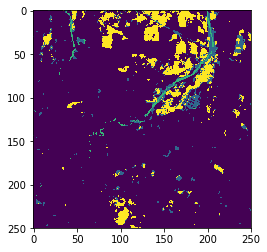

In [16]:
# Verify the authenticity of the output save_classified function
outRaster = gdal.Open("Linear.tif")
plt.imshow(outRaster.GetRasterBand(1).ReadAsArray())
plt.show()

In [17]:
!gdalinfo Linear.tif

Driver: GTiff/GeoTIFF
Files: Linear.tif
Size is 250, 250
Coordinate System is:
PROJCS["WGS 84 / UTM zone 15N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-93],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32615"]]
Origin = (462405.000000000000000,1741815.000000000000000)
Pixel Size = (30.000000000000000,-30.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Stru